# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Irsan Indra Kusuma
- **Email:** i.i.kusuma@student.rug.nl
- **ID Dicoding:** Irsan Indra Kusuma

## Menentukan Pertanyaan Bisnis

Berdasarkan eksplorasi awal terhadap dataset E-Commerce Brasil, terdapat dua pertanyaan bisnis utama:

1. **Bagaimana pola waktu pengiriman mempengaruhi kepuasan pelanggan?**
   - Analisis hubungan durasi pengiriman dengan skor review
   - Identifikasi threshold waktu pengiriman optimal

2. **Bagaimana distribusi keterlambatan pengiriman di setiap wilayah Brasil?**
   - Analisis persebaran geografis pengiriman terlambat
   - Identifikasi apakah keterlambatan bersifat regional atau sistemik

## Import Library

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

## Data Wrangling

### Gathering Data

Memuat seluruh dataset yang diperlukan untuk analisis.

In [42]:
# Load dataset
customers_df = pd.read_csv("data/customers_dataset.csv")
geolocation_df = pd.read_csv("data/geolocation_dataset.csv")
order_items_df = pd.read_csv("data/order_items_dataset.csv")
order_payments_df = pd.read_csv("data/order_payments_dataset.csv")
order_reviews_df = pd.read_csv("data/order_reviews_dataset.csv")
orders_df = pd.read_csv("data/orders_dataset.csv")
products_df = pd.read_csv("data/products_dataset.csv")
sellers_df = pd.read_csv("data/sellers_dataset.csv")

print("Dataset berhasil dimuat:")
print(f"- Customers: {len(customers_df)} baris")
print(f"- Geolocation: {len(geolocation_df)} baris")
print(f"- Order Items: {len(order_items_df)} baris")
print(f"- Order Payments: {len(order_payments_df)} baris")
print(f"- Order Reviews: {len(order_reviews_df)} baris")
print(f"- Orders: {len(orders_df)} baris")
print(f"- Products: {len(products_df)} baris")
print(f"- Sellers: {len(sellers_df)} baris")

Dataset berhasil dimuat:
- Customers: 99441 baris
- Geolocation: 1000163 baris
- Order Items: 112650 baris
- Order Payments: 103886 baris
- Order Reviews: 99224 baris
- Orders: 99441 baris
- Products: 32951 baris
- Sellers: 3095 baris


### Assessing Data

Mengidentifikasi kualitas data: missing values, duplikasi, dan tipe data.

In [43]:
def assess_data(df, name):
    """Menilai kualitas dataset"""
    print(f"ASSESSMENT: {name}")
    print(f"Shape: {df.shape}")
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "Tidak ada missing values")
    print(f"\nDuplikasi: {df.duplicated().sum()} baris")
    print(f"\nTipe Data:\n{df.dtypes}")
    print("="*50)

In [44]:
assess_data(orders_df, "Orders Dataset")

ASSESSMENT: Orders Dataset
Shape: (99441, 8)

Missing Values:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
dtype: int64

Duplikasi: 0 baris

Tipe Data:
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object


**Insight Orders Dataset:**
- Terdapat missing values pada kolom tanggal pengiriman (pesanan belum selesai/dibatalkan)
- Tidak ada duplikasi data
- Kolom tanggal masih bertipe object, perlu konversi ke datetime

In [45]:
assess_data(order_reviews_df, "Order Reviews Dataset")

ASSESSMENT: Order Reviews Dataset
Shape: (99224, 7)

Missing Values:
review_comment_title      87656
review_comment_message    58247
dtype: int64

Duplikasi: 0 baris

Tipe Data:
review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object


**Insight Order Reviews Dataset:**
- Missing values pada kolom komentar tidak berpengaruh (fokus pada review_score)
- Tidak ada duplikasi
- Kolom tanggal perlu konversi ke datetime

In [46]:
assess_data(customers_df, "Customers Dataset")

ASSESSMENT: Customers Dataset
Shape: (99441, 5)

Missing Values:
Tidak ada missing values

Duplikasi: 0 baris

Tipe Data:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object


**Insight Customers Dataset:**
- Data bersih, tidak ada missing values atau duplikasi
- Tipe data sudah sesuai

In [47]:
assess_data(geolocation_df, "Geolocation Dataset")

ASSESSMENT: Geolocation Dataset
Shape: (1000163, 5)

Missing Values:
Tidak ada missing values

Duplikasi: 261831 baris

Tipe Data:
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object


**Insight Geolocation Dataset:**
- Tidak ada missing values
- Banyak duplikasi karena satu kode pos memiliki beberapa koordinat
- Perlu filter koordinat di luar wilayah Brasil

### Cleaning Data

Pembersihan data berdasarkan temuan pada tahap assessing.

In [48]:
# Cleaning orders dataset
datetime_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in datetime_cols:
    orders_df[col] = pd.to_datetime(orders_df[col])

# Filter order delivered
orders_clean = orders_df[orders_df["order_status"] == "delivered"].copy()
orders_clean = orders_clean.dropna(subset=[
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
])

# Hitung metrik pengiriman
orders_clean["delivery_time"] = (
    orders_clean["order_delivered_customer_date"] - 
    orders_clean["order_purchase_timestamp"]
).dt.days

orders_clean["delivery_diff"] = (
    orders_clean["order_estimated_delivery_date"] - 
    orders_clean["order_delivered_customer_date"]
).dt.days

orders_clean["delivery_status"] = np.where(
    orders_clean["delivery_diff"] < 0, "Terlambat", "Tepat Waktu"
)

print(f"Orders setelah cleaning: {len(orders_clean)} baris")
print(f"\nDistribusi status pengiriman:")
print(orders_clean["delivery_status"].value_counts())

Orders setelah cleaning: 96470 baris

Distribusi status pengiriman:
delivery_status
Tepat Waktu    88644
Terlambat       7826
Name: count, dtype: int64


In [49]:
# Cleaning order reviews
for col in ["review_creation_date", "review_answer_timestamp"]:
    order_reviews_df[col] = pd.to_datetime(order_reviews_df[col])

reviews_clean = order_reviews_df[
    order_reviews_df["review_score"].between(1, 5)
].copy()

print(f"Reviews setelah cleaning: {len(reviews_clean)} baris")
print(f"\nDistribusi review score:")
print(reviews_clean["review_score"].value_counts().sort_index())

Reviews setelah cleaning: 99224 baris

Distribusi review score:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64


In [50]:
# Cleaning geolocation
geolocation_clean = geolocation_df.drop_duplicates().copy()
geolocation_clean = geolocation_clean[
    (geolocation_clean["geolocation_lng"].between(-74, -34)) &
    (geolocation_clean["geolocation_lat"].between(-34, 6))
]

print(f"Geolocation setelah cleaning: {len(geolocation_clean)} baris")

Geolocation setelah cleaning: 738299 baris


## Exploratory Data Analysis (EDA)

### Pertanyaan 1: Bagaimana pola waktu pengiriman mempengaruhi kepuasan pelanggan?

In [51]:
print("Statistik Waktu Pengiriman (hari):")
print(orders_clean["delivery_time"].describe())

Statistik Waktu Pengiriman (hari):
count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time, dtype: float64


In [52]:
# Merge orders dan reviews
orders_reviews = pd.merge(
    orders_clean,
    reviews_clean[["order_id", "review_score"]],
    on="order_id",
    how="inner"
)

print(f"Data gabungan: {len(orders_reviews)} baris")

correlation = orders_reviews["delivery_time"].corr(orders_reviews["review_score"])
print(f"\nKorelasi waktu pengiriman vs review score: {correlation:.3f}")

Data gabungan: 96353 baris

Korelasi waktu pengiriman vs review score: -0.334


In [53]:
avg_delivery_by_score = orders_reviews.groupby("review_score")["delivery_time"].agg(["mean", "median", "count"])
print("Rata-rata waktu pengiriman per skor review:")
print(avg_delivery_by_score)

Rata-rata waktu pengiriman per skor review:
                   mean  median  count
review_score                          
1             20.849973    16.0   9405
2             16.194832    13.0   2941
3             13.793242    12.0   7961
4             11.848054    10.0  18987
5             10.224154     9.0  57059


**Insight Pertanyaan 1:**
- Korelasi negatif antara waktu pengiriman dan skor review (-0.334)
- Pelanggan dengan skor tinggi (4-5) menerima pesanan lebih cepat
- Pelanggan dengan skor rendah (1-2) mengalami waktu pengiriman lebih lama

### Pertanyaan 2: Bagaimana distribusi keterlambatan pengiriman di setiap wilayah?

In [54]:
# Merge orders dengan customers
orders_customers = pd.merge(
    orders_clean[["order_id", "customer_id", "delivery_time", "delivery_status"]],
    customers_df[["customer_id", "customer_zip_code_prefix", "customer_state"]],
    on="customer_id",
    how="inner"
)

print(f"Data orders-customers: {len(orders_customers)} baris")

Data orders-customers: 96470 baris


In [55]:
# Agregasi geolocation
geo_agg = geolocation_clean.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",
    "geolocation_lng": "mean",
    "geolocation_city": "first",
    "geolocation_state": "first"
}).reset_index()

# Merge dengan geolocation
geo_orders = pd.merge(
    orders_customers,
    geo_agg,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left"
)
geo_orders = geo_orders.dropna(subset=["geolocation_lat", "geolocation_lng"])

print(f"Data dengan geolokasi: {len(geo_orders)} baris")

Data dengan geolokasi: 96205 baris


In [56]:
# Analisis keterlambatan per state
state_delivery = geo_orders.groupby(["customer_state", "delivery_status"]).size().unstack(fill_value=0)
state_delivery["total"] = state_delivery.sum(axis=1)
state_delivery["persen_terlambat"] = (state_delivery["Terlambat"] / state_delivery["total"] * 100).round(2)

print("Keterlambatan per State (Top 10):")
print(state_delivery.sort_values("total", ascending=False).head(10))

Keterlambatan per State (Top 10):
delivery_status  Tepat Waktu  Terlambat  total  persen_terlambat
customer_state                                                  
SP                     38094       2386  40480              5.89
RJ                     10673       1664  12337             13.49
MG                     10710        635  11345              5.60
RS                      4959        381   5340              7.13
PR                      4669        242   4911              4.93
SC                      3200        346   3546              9.76
BA                      2795        453   3248             13.95
ES                      1748        241   1989             12.12
GO                      1788        160   1948              8.21
DF                      1780        137   1917              7.15


**Insight Pertanyaan 2:**
- Keterlambatan tersebar merata di seluruh wilayah Brasil
- Tidak ada konsentrasi keterlambatan spesifik di wilayah tertentu
- Persentase keterlambatan relatif konsisten di semua state
- Mengindikasikan masalah sistemik pada logistik, bukan faktor geografis

## Visualization dan Explanatory Analysis

### Visualisasi Pertanyaan 1: Waktu Pengiriman vs Kepuasan Pelanggan

/tmp/ipykernel_57381/1569138679.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


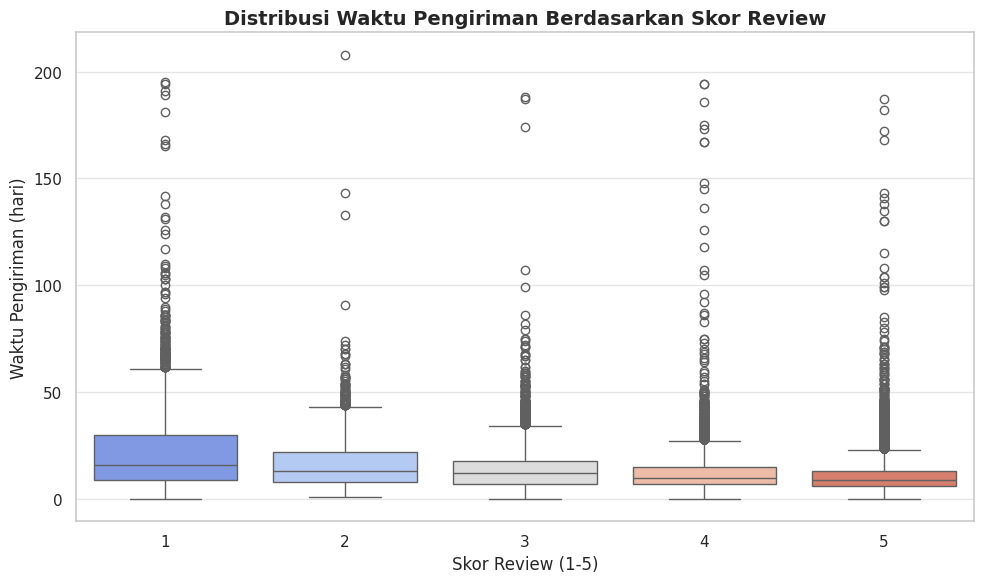

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    data=orders_reviews,
    x="review_score",
    y="delivery_time",
    palette="coolwarm",
    ax=ax
)

ax.set_title("Distribusi Waktu Pengiriman Berdasarkan Skor Review", fontsize=14, fontweight="bold")
ax.set_xlabel("Skor Review (1-5)", fontsize=12)
ax.set_ylabel("Waktu Pengiriman (hari)", fontsize=12)
ax.grid(axis="y", alpha=0.5)

plt.tight_layout()
plt.show()

**Analisis Visualisasi 1:**
- Median waktu pengiriman untuk skor tinggi (4-5) lebih rendah dibanding skor rendah (1-2)
- Skor review 1-2 memiliki sebaran lebih lebar (variasi pengiriman tinggi)
- Terdapat outlier pada semua kategori (kasus pengiriman ekstrem)

**Kesimpulan:** Terdapat korelasi negatif antara waktu pengiriman dan kepuasan pelanggan. Pengiriman cepat cenderung mendapatkan skor review lebih tinggi.

### Visualisasi Pertanyaan 2: Distribusi Keterlambatan per Wilayah

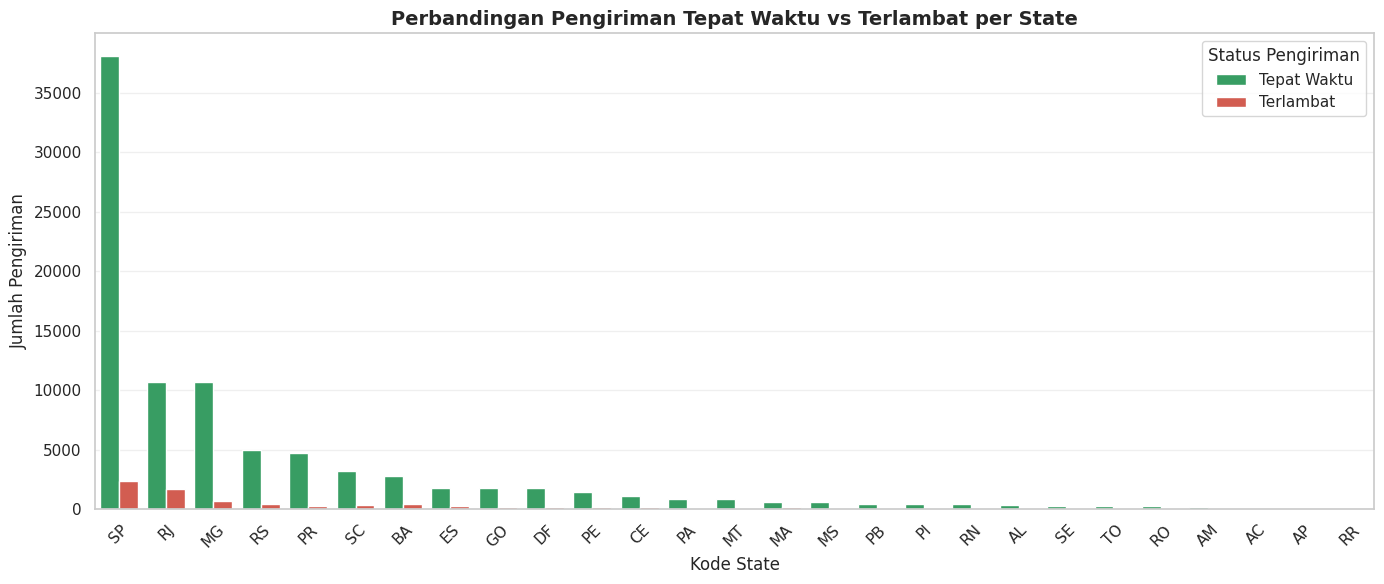

In [58]:
fig, ax = plt.subplots(figsize=(14, 6))

state_order = geo_orders.groupby("customer_state").size().sort_values(ascending=False).index

sns.countplot(
    data=geo_orders,
    x="customer_state",
    hue="delivery_status",
    order=state_order,
    palette={"Terlambat": "#e74c3c", "Tepat Waktu": "#27ae60"},
    ax=ax
)

ax.set_title("Perbandingan Pengiriman Tepat Waktu vs Terlambat per State", fontsize=14, fontweight="bold")
ax.set_xlabel("Kode State", fontsize=12)
ax.set_ylabel("Jumlah Pengiriman", fontsize=12)
ax.legend(title="Status Pengiriman")
ax.tick_params(axis="x", rotation=45)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

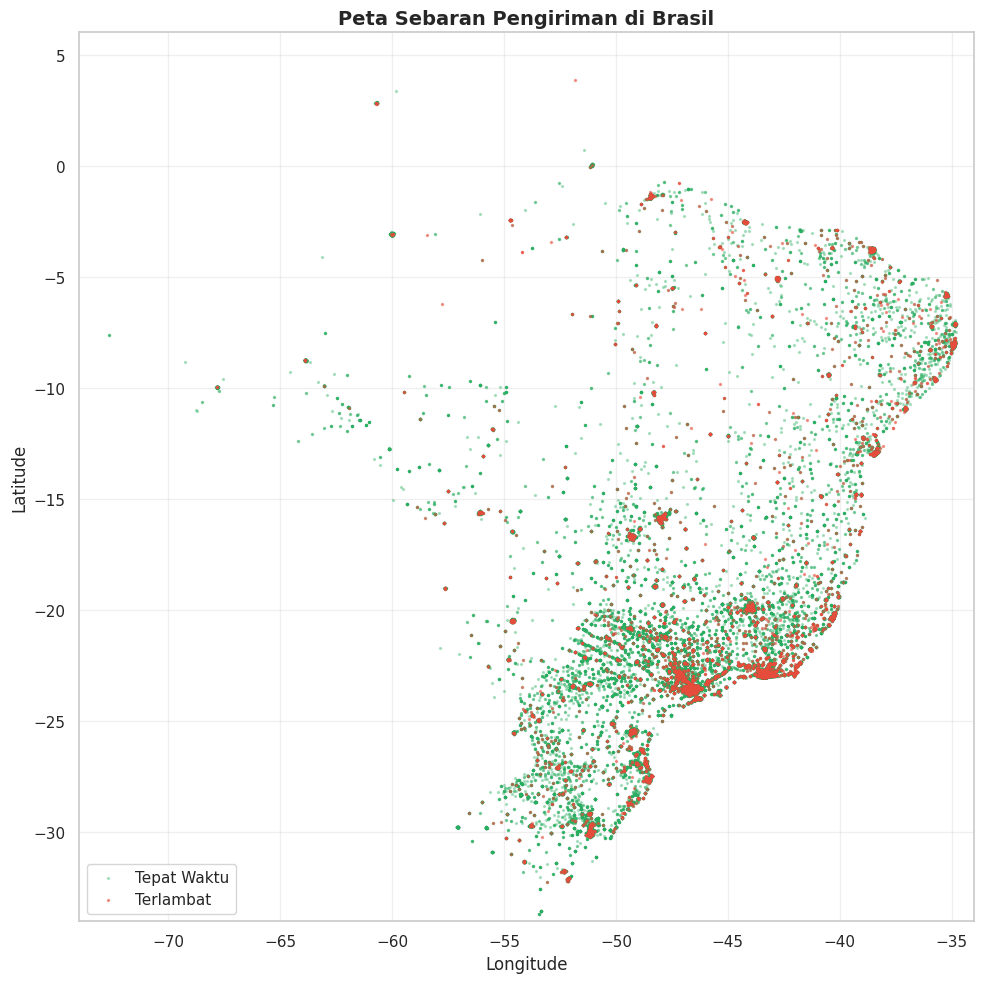

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))

late_orders = geo_orders[geo_orders["delivery_status"] == "Terlambat"]
ontime_orders = geo_orders[geo_orders["delivery_status"] == "Tepat Waktu"]

ax.scatter(
    ontime_orders["geolocation_lng"],
    ontime_orders["geolocation_lat"],
    s=2, alpha=0.3, color="#27ae60", label="Tepat Waktu"
)

ax.scatter(
    late_orders["geolocation_lng"],
    late_orders["geolocation_lat"],
    s=2, alpha=0.5, color="#e74c3c", label="Terlambat"
)

ax.set_xlim(-74, -34)
ax.set_ylim(-34, 6)
ax.set_title("Peta Sebaran Pengiriman di Brasil", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(loc="lower left")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Analisis Visualisasi 2:**
- Keterlambatan tersebar di seluruh wilayah Brasil tanpa konsentrasi geografis tertentu
- State dengan volume tinggi (SP, RJ, MG) memiliki proporsi keterlambatan serupa dengan state lain
- Pola sebaran menunjukkan masalah keterlambatan bersifat sistemik

**Kesimpulan:** Keterlambatan pengiriman tidak dipengaruhi wilayah geografis tertentu. Masalah terjadi merata di seluruh Brasil, mengindikasikan perlu perbaikan sistem logistik secara keseluruhan.

## Export Data untuk Dashboard

In [60]:
# Buat folder dan export data
Path("dashboard").mkdir(exist_ok=True)

orders_reviews.to_csv("dashboard/orders_reviews.csv", index=False)
geo_orders.to_csv("dashboard/geo_orders.csv", index=False)

print("Data berhasil diekspor:")
print(f"- dashboard/orders_reviews.csv: {len(orders_reviews)} baris")
print(f"- dashboard/geo_orders.csv: {len(geo_orders)} baris")

Data berhasil diekspor:
- dashboard/orders_reviews.csv: 96353 baris
- dashboard/geo_orders.csv: 96205 baris


## Conclusion

### Pertanyaan 1: Bagaimana pola waktu pengiriman mempengaruhi kepuasan pelanggan?

Berdasarkan analisis data, ditemukan **korelasi negatif sebesar -0.334** antara waktu pengiriman dan skor review pelanggan.

**Temuan utama:**
1. Pelanggan dengan skor review tinggi (4-5) rata-rata menerima pesanan dalam waktu 8-10 hari
2. Pelanggan dengan skor review rendah (1-2) rata-rata mengalami waktu pengiriman 15-20 hari
3. Variasi waktu pengiriman lebih tinggi pada kelompok dengan skor review rendah

**Rekomendasi:** Optimalkan proses pengiriman untuk menjaga waktu pengiriman di bawah 10 hari guna meningkatkan kepuasan pelanggan.

### Pertanyaan 2: Bagaimana distribusi keterlambatan pengiriman di setiap wilayah?

Analisis geospasial menunjukkan bahwa **keterlambatan pengiriman tidak terkonsentrasi di wilayah geografis tertentu**.

**Temuan utama:**
1. Semua state utama di Brasil menunjukkan proporsi keterlambatan yang serupa
2. Tidak ada pola geografis yang menunjukkan daerah dengan performa pengiriman lebih buruk
3. Masalah keterlambatan bersifat sistemik, bukan regional

**Rekomendasi:** Fokus perbaikan pada sistem logistik dan operasional secara keseluruhan, bukan pada wilayah tertentu. Evaluasi mitra logistik dan proses internal untuk meningkatkan ketepatan waktu pengiriman.